<a href="https://colab.research.google.com/github/hrithiks2019/Thermal_analysis/blob/master/Thermal_Analysis_V32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if The Nvidia GPU is Available or Not :
!nvidia-smi

Thu Aug 13 02:30:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Installing Requirments:
!sudo apt install tesseract-ocr
!pip install reportlab
!pip install pytesseract
!git clone https://github.com/hrithiks2019/Thermal_analysis.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,988 kB/s)
debconf: unable to initi

In [3]:
# Import Required Libraries:
import os
import cv2
import json
import time
import numpy as np
import pytesseract
import tensorflow.keras
from datetime import datetime
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from reportlab.lib import colors
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

In [6]:
# Getting Required Functions :

def get_max_temp(filepathy1):
    temp_im = Image.open(filepathy1)
    max_temp_reading_image = temp_im.crop((278, 42, 318, 64))
    max_temp_reading_image.save("TEMP.png")
    img = cv2.imread("TEMP.png")
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray, img_bin = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    gray = cv2.bitwise_not(img_bin)
    kernel = np.ones((2, 1), np.uint8)
    img = cv2.erode(gray, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    max_temp_reading = pytesseract.image_to_string(img)
    max_temp_reading = str(max_temp_reading[:-1]+"."+max_temp_reading[-1])
    os.remove("TEMP.png")
    try:
        tempi = float(max_temp_reading)
    except ValueError:
        tempi = (32.12 + 12.18)
    return tempi


def max_temp_pixel_value(filepathy2):
    im = Image.open(filepathy2)
    coordinate = x, y = 310, 70
    xfi = list(im.getpixel(coordinate))
    xfi.reverse()
    return xfi


def get_object(filepathy):
    f = open('/content/Thermal_analysis/Support/labels.txt', 'r+')
    objects = [line[2:-1] for line in f.readlines()]
    model_path = '/content/Thermal_analysis/Support/keras_model.h5'
    np.set_printoptions(suppress=True)
    model = tensorflow.keras.models.load_model(model_path)
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(filepathy)
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    data[0] = normalized_image_array
    prediction_list = (list(model.predict(data)))[0]
    predicted_max = max((list(model.predict(data)))[0])
    try:
        idx = list(np.where(prediction_list == predicted_max))[0][0]
        predicted_object = objects[idx]
    except IndexError:
        predicted_object = 'Object Not Classified in the Trained Model'
    f.close()
    return predicted_object


def display_multiple_img(images, rows, cols):
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    for ind, title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    figure.set_size_inches(5, 5)
    plt.tight_layout()
    plt.savefig('temp_fig.png')


def gen_pdf_file(filename, data):
    title, subtitle = 'THERMAL ANALYSIS', 'System Study'
    image = 'temp_fig.png'
    pdf = canvas.Canvas(filename)
    pdf.setTitle(filename)
    pdfmetrics.registerFont(TTFont('abc', '/content/Thermal_analysis/Support/SakBunderan.ttf'))
    pdf.setFont('abc', 36)
    pdf.drawCentredString(300, 770, title)
    pdf.setFillColorRGB(0, 0, 255)
    pdf.setFont("Courier-Bold", 24)
    pdf.drawCentredString(290, 720, subtitle)
    pdf.line(30, 710, 550, 710)
    text = pdf.beginText(40, 680)
    text.setFont("Courier", 16)
    text.setFillColor(colors.red)
    for line in data:
        text.textLine(line)
    pdf.drawText(text)
    pdf.setFillColorRGB(0, 0, 255)
    pdf.setFont("Courier-Bold", 24)
    pdf.drawCentredString(300, 450, 'Image Analysis')
    pdf.line(30, 440, 550, 440)
    pdf.drawInlineImage(image, 90, 0)
    os.remove('temp_fig.png')
    pdf.save()

[INFO] Process Running: Object Detection 
[INFO] Process Running: Getting Temperature Reading at the Hottest Area of the Object 
[INFO] Process Running: Setting The Upper Scale Spectrum for Thermal Analysis 
[INFO] Proceeding To Analyse the Two Images
[INFO] ANALYSING ACQUIRED DATA
[INFO] Analysis Completed
[INFO] Report Has Been Generated saving as : Report_13-08-2020_023721.pdf
[INFO] Now Opening the Report PDF File
 
       PARAMETERS               ANALYSED-OUTPUT        
                                                       
OBJECT CLASSIFICATION  :  Wire_or_Junction
OBJECT TEMPERATURE     :  77.7 celcius
NOMINAL TEMPERATURE    :  40 Celcius
TOLERANCE TEMPERATURE  :  90 Celcius
RISK ESTIMATION        :  MEDIUM RISK
CURRENT STATE          :  37.7 Deg Higher than Normal
ANALYTICAL OPINION     :  TECHNICIAN SHOULD TAKE A LOOK
LONGEVITY ANALYSIS     :  12-18 Months                 
 
[INFO] Process Completed


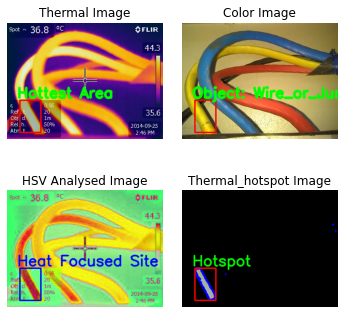

In [9]:
# Main Function :

normal_image_path = "/content/Thermal_analysis/main_data_set/test_normal_wire.jpg"
thermal_image_path = "/content/Thermal_analysis/main_data_set/test_thermal_wire.jpg"
paramter_json = open('/content/Thermal_analysis/Support/parameter.json', "r")

paramters = json.loads(paramter_json.read())
filename = 'Report_' + str(datetime.now().strftime("%d-%m-%Y_%H%M%S")) + '.pdf'
object_dxi = 'UNKNOWN'
final_report = ['       PARAMETERS               ANALYSED-OUTPUT        ',
                '                                                       ']
k_constant = 100
print('[INFO] Process Running: Object Detection ')
object_dxi = get_object(thermal_image_path)
print('[INFO] Process Running: Getting Temperature Reading at the Hottest Area of the Object ')
maxi_temp = get_max_temp(thermal_image_path)
print('[INFO] Process Running: Setting The Upper Scale Spectrum for Thermal Analysis ')
upper = max_temp_pixel_value(thermal_image_path)
print('[INFO] Proceeding To Analyse the Two Images')

lower = [upper[0] - k_constant, upper[1] - k_constant, upper[2] - k_constant]
lower = np.array(lower, dtype="uint8")
upper = np.array(upper, dtype="uint8")
normal_image = cv2.imread(normal_image_path)
thermal_image = cv2.imread(thermal_image_path)
hsv = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(thermal_image, lower, upper)
output = cv2.bitwise_and(thermal_image, thermal_image, mask=mask)
ret, thresh = cv2.threshold(mask, 40, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if len(contours) != 0:
    cv2.drawContours(output, contours, -1, 255, 3)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    org = (x - 5, y - 5)
    cv2.rectangle(normal_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(normal_image, 'Object: ' + str(object_dxi), org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3,
                cv2.LINE_AA)
    cv2.rectangle(thermal_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(thermal_image, 'Hottest Area', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(output, 'Hotspot', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(hsv, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(hsv, 'Heat Focused Site', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

thermal_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
results = {"Thermal Image": thermal_image, "Color Image": normal_image,
           "HSV Analysed Image": hsv, "Thermal_hotspot Image": output}
print('[INFO] ANALYSING ACQUIRED DATA')

final_report.append('OBJECT CLASSIFICATION  :  {0}'.format(str(object_dxi)))
final_report.append('OBJECT TEMPERATURE     :  {0} celcius'.format(maxi_temp))
final_report.append('NOMINAL TEMPERATURE    :  {0} Celcius'.format(paramters[object_dxi]['normal_temp']))
final_report.append('TOLERANCE TEMPERATURE  :  {0} Celcius'.format(paramters[object_dxi]['max_temp']))
if maxi_temp > paramters[object_dxi]['max_temp']:
    final_report.append('RISK ESTIMATION        :  HIGH RISK')
    final_report.append('CURRENT STATE          :  {0} Deg Higher than Tolerance'.
                        format(round(maxi_temp - (paramters[object_dxi]['max_temp']), 2)))
    final_report.append('ANALYTICAL OPINION     :  This component Should Be Taken Offline and '
                        'Analysed by Technician Immediately.')
    final_report.append('LONGEVITY ANALYSIS     :  0-1 Months')
elif maxi_temp < paramters[object_dxi]['max_temp']:
    final_report.append('RISK ESTIMATION        :  MEDIUM RISK')
    final_report.append('CURRENT STATE          :  {0} Deg Higher than Normal'.
                        format(round(maxi_temp - (paramters[object_dxi]['normal_temp']), 2)))
    final_report.append('ANALYTICAL OPINION     :  TECHNICIAN SHOULD TAKE A LOOK')
    final_report.append('LONGEVITY ANALYSIS     :  12-18 Months                 ')
else:
    final_report.append('RISK ESTIMATION        : LOW RISK')
    final_report.append('CURRENT STATE: It is Well Within Limits')
    final_report.append('ANALYTICAL OPINION: NONE')
    final_report.append('LONGEVITY ANALYSIS: 2-3 YEARS')


display_multiple_img(results, 2, 2)
gen_pdf_file(filename, final_report)
print('[INFO] Analysis Completed')
print('[INFO] Report Has Been Generated saving as : {0}'.format('Report_' + str(
        datetime.now().strftime("%d-%m-%Y_%H%M%S")) + '.pdf'))
print('[INFO] Now Opening the Report PDF File')
time.sleep(2)
print(" ")
# If you want Printed Report change the False to True in the Below Condition
if True: # Change this. 
    for shitty_report in final_report:
        print(shitty_report)
    print(" ")

print("[INFO] Process Completed")